<a href="https://colab.research.google.com/github/ElZho/Translate-from-old-russian-language.Seq2seq-model./blob/main/NLP_translate_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseline - [Pytorch tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import tqdm
from tqdm import tqdm

In [3]:
import unicodedata
import string
import re
import random
import itertools

In [4]:
import time
import math
from collections import defaultdict

In [5]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import seaborn as sns

In [6]:
import os
from pathlib import Path
import sys

In [7]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./drive/My\ Drive/NLP_translation/* . 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
from preprocessing import prepareData, readLangs, tensorsFromPair, tensorFromSentence

In [9]:
config = {  
    'path'  :'/content/drive/MyDrive/NLP_translation/old_slav.txt',
    # 'path':'/content/rus.txt',
    'MAX_LENGTH':60,
    'reverse':True,
    
    'batch_size':16, # for short datasets use batch_size - 8, for big dataset - 256

    'teacher_forcing_ratio': 0.5,
    'hidden_size':256,
    'num_epochs':6,
    
    'lr': 0.01
}

In [10]:
from model import EncoderRNN, AttnDecoderRNN, TONModel

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Upload and prepere data. Check length of the sentence, drop longer sentence then max length. Tokenize. Pad the sentence, which then max length.

In [12]:
train_input_lang, train_output_lang, train_pairs, test_input_lang,\
           test_output_lang, test_pairs = prepareData('old_rus', 'new_rus', config['path'], config['MAX_LENGTH'], config['reverse'])
print(random.choice(train_pairs))

Reading lines...


100%|██████████| 208/208 [00:00<00:00, 570952.38it/s]

Read 144 sentence pairs train
Read 62 sentence pairs test
Trimmed to 144 sentence train pairs
Trimmed to 62 sentence test pairs
Counting words...
Counted words train:
old_rus 735
new_rus 708
Counted words test:
old_rus 399
new_rus 381
['отъ чина бо почиваеть и звѣрь  и пътици и человѣци', 'ибо по этому установленью отдыхают и зверь  и птицы  и люди']


Look at the data. Max lenght of train dataset.

In [ ]:
len_train=([len(pair[0]), len(pair[1])] for pair in train_pairs)
max(len_train)

[197, 210]

Max lenght of test dataset.

In [39]:
max([len(pair[0]), len(pair[1])] for pair in test_pairs)

[203, 190]

Calculation of the length of the sentence.

In [ ]:
def len_pair(pair):
  len_0=len(pair[0])
  len_1=len(pair[1])
  return len_0, len_1
len_train_old=[] 
len_train_new=[] 
for pair in train_pairs:  
  old, new=len_pair(pair)
  len_train_old.append(old)
  len_train_new.append(new)

Look at the sentence, which is longer then 150 symbols.

In [ ]:
big_pair=[pair[1] for pair in train_pairs if len(pair[1])>150]
big_pair

['вот что рассказал своим ученикам отец пафнутии  услышав это от тех  кого батыи поставил властителями по русским городам и кто называется на языке тех народов баскаками ',
 'и вот в тот город пришли странники  увидев их  обрадовавшись  юноша  побежав  поклонился им  с любовью приветствовал их и спросил их  откуда они и куда идут ',
 'однажды  когда я стоял в москве в соборнои церкви честного успения владычицы нашеи богородицы  я увидел некоего человека  которыи усердно молился великомученику никите и пытался узнать  где находится его икона ',
 'горлица – птица  любящая своего супруга  и если погибнет один из них   уходит другои в пустыню и садится на засохшем дереве  плача по своему супругу  что больше не соединится с ним никогда ',
 'сын  непослушныи отцу или матери  которыи гневит отца и досаждает матери  считающии себя праведным перед богом  но он хуже язычника  сообщник нечестивых ']

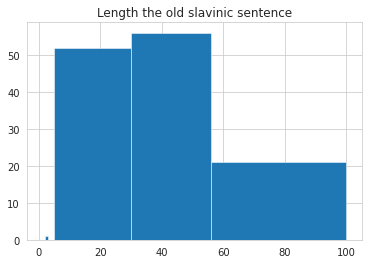

In [37]:
fig, ax = plt.subplots()
ax.hist(len_train_old, bins=[1.1, 2.1, 3.1, 5, 30, 56, 100], linewidth=0.5, edgecolor="white")
plt.title('Length the old slavinic sentence');



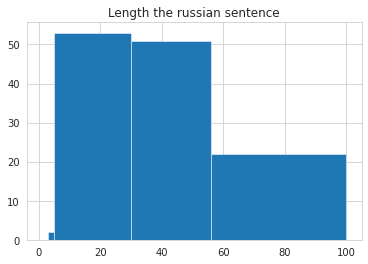

In [38]:
fig, ax = plt.subplots()
ax.hist(len_train_new, bins=[1.1, 2.1, 3.1, 5, 30, 56, 100], linewidth=0.5, edgecolor="white")
plt.title('Length the russian sentence');

Prepare train and test loader.

In [13]:
training_pairs = [tensorsFromPair(train_pair, train_input_lang, train_output_lang, MAX_LENGTH=config['MAX_LENGTH'])
                      for train_pair in tqdm(train_pairs)]

100%|██████████| 144/144 [00:02<00:00, 52.67it/s]


In [14]:
testing_pairs = [tensorsFromPair(test_pair, test_input_lang, test_output_lang, MAX_LENGTH=config['MAX_LENGTH'])
                      for test_pair in tqdm(test_pairs)]

100%|██████████| 62/62 [00:00<00:00, 10730.66it/s]


In [15]:
train_loader = torch.utils.data.DataLoader(training_pairs, batch_size=config['batch_size'], shuffle=True)

In [16]:
test_loader = torch.utils.data.DataLoader(testing_pairs, batch_size=config['batch_size'], shuffle=True)

Helper function.

In [17]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [18]:
def plot_learning_curves(history):
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(10,5))

    # plt.subplot(1,3,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

Train function.

In [19]:
#model with data loader
def train_modelIters(model, optimizer, loader, test_loader, num_epochs=6):
    start = time.time()
    itog_losses = []
    
    history = defaultdict(lambda: defaultdict(list))
    
      
    criterion = nn.NLLLoss()
    for epoch in tqdm(range(num_epochs), desc='epochs'):
      model.train(True)
      
      plot_losses = []
      
      plot_loss_total = 0

      val_losses = []
      val_loss_total = 0  
      
      #train loop
      for batch in tqdm(loader, desc='train sample batches'):
          
          input_tensor = batch[0].to(device)
          target_tensor = batch[1].to(device)

          
          decoder_outputs = model(input_tensor[:,:,0], target_tensor[:,:,0])
          target_tensor = target_tensor.view(-1)
          output_dim = decoder_outputs.shape[-1]  
          decoder_outputs=decoder_outputs.view(-1, output_dim)  
          
          loss = criterion(decoder_outputs, target_tensor)   
          
          loss.backward(retain_graph=True)    
          optimizer.step()
          optimizer.zero_grad()
          optimizer.zero_grad()
          
          plot_loss_total += loss.item()

      
      plot_loss_avg = plot_loss_total /  len(loader)
      history['loss']['train'].append(plot_loss_avg)
      
      #val loop
      model.train(False)
      
      for batch in tqdm(test_loader, desc='validation sample batches'):
        
        input_tensor = batch[0].to(device)
        target_tensor = batch[1].to(device)
        
        with torch.no_grad():

          decoder_outputs = model(input_tensor[:,:,0], target_tensor[:,:,0],
                                  evalute=True)

          target_tensor = target_tensor.view(-1)
          output_dim = decoder_outputs.shape[-1]  
          
          decoder_outputs=decoder_outputs.view(-1, output_dim)    

          val_loss = criterion(decoder_outputs, target_tensor)
          
          val_loss_total+= loss.item()
      #print losses
      val_loss_avg = val_loss_total / len(test_loader)    
      history['loss']['val'].append(val_loss_avg)
      print('Epoch train loss', plot_loss_avg, end='\n')
      print('Epoch val_loss', val_loss_avg, end='\n')

    #plot losses
    plot_learning_curves(history)
    return

Train model

train sample batches: 100%|██████████| 9/9 [00:00<00:00, 12.50it/s]

epochs:  17%|█▋        | 1/6 [00:00<00:04,  1.17it/s]

Epoch train loss 5.2938136259714765
Epoch val_loss 3.902599573135376



train sample batches: 100%|██████████| 9/9 [00:00<00:00, 12.60it/s]

epochs:  33%|███▎      | 2/6 [00:01<00:03,  1.18it/s]

Epoch train loss 2.1991949213875666
Epoch val_loss 1.7156134843826294



train sample batches: 100%|██████████| 9/9 [00:00<00:00, 12.48it/s]

epochs:  50%|█████     | 3/6 [00:02<00:02,  1.17it/s]

Epoch train loss 1.4379188219706218
Epoch val_loss 1.5484825372695923



train sample batches: 100%|██████████| 9/9 [00:00<00:00, 12.65it/s]

epochs:  67%|██████▋   | 4/6 [00:03<00:01,  1.18it/s]

Epoch train loss 1.4205320411258273
Epoch val_loss 1.1046478748321533



train sample batches: 100%|██████████| 9/9 [00:00<00:00, 12.52it/s]

epochs:  83%|████████▎ | 5/6 [00:04<00:00,  1.17it/s]

Epoch train loss 1.4145083294974432
Epoch val_loss 1.403796911239624



train sample batches: 100%|██████████| 9/9 [00:00<00:00, 12.37it/s]

epochs: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Epoch train loss 1.4094111522038777
Epoch val_loss 1.6871730089187622


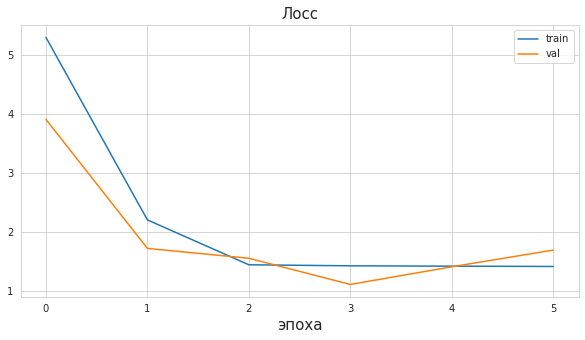

In [20]:
encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'])
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.SGD(model.parameters(), lr=config['lr'])

train_modelIters(model, optimizer, train_loader, test_loader, config['num_epochs'])

Look at the model

In [42]:
model

TONModel(
  (encoder): EncoderRNN(
    (embedding): Embedding(775, 256)
    (gru): GRU(256, 256, batch_first=True)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(727, 256)
    (attn): Linear(in_features=512, out_features=60, bias=True)
    (attn_combine): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (gru): GRU(256, 256, batch_first=True)
    (out): Linear(in_features=256, out_features=727, bias=True)
  )
)